https://stackoverflow.com/questions/44802939/hyperparameter-tuning-of-tensorflow-model

https://github.com/ray-project/tutorial/blob/master/tune_exercises/exercise_1_basics.ipynb

# Introduction

Build a simple Convolutional Neural Network (CNN) and train it to solve a handwritten digits classification problem with Keras.

In [110]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

import matplotlib.pyplot as plt
%matplotlib inline

from pandas import DataFrame
import numpy as np
import seaborn as sn

import os.path
from os import path

# 1. Data Preparation

MNIST handwritten digit dataset is 28x28 and contains a centered, grayscale digit. Our CNN will take an image and output one of 10 possible classes (one for each digit).

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
print(train_images.shape)
print('Number of image:',train_images.shape[0])
print('Height of image:',train_images.shape[1])
print('Width of image:',train_images.shape[2])

(60000, 28, 28)
Number of image: 60000
Height of image: 28
Width of image: 28


Training image example:

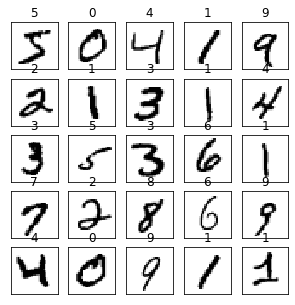

In [3]:
figure = plt.figure(figsize=(5,5))
for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title=train_labels[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)

## 1.1. Reshape Images Into 4 Dimensions
    4 Dimensions: (Number of image, image_height, image_width, color_channels)
    
    For color images, the number of channels is 3 (red, green, blue). 
    For monochrome images, the number of channels is 1 (black).

### 1.2. Normalization

Scale these values to a range of 0 to 1 before feeding to the neural network model. 
For this, we divide the values by 255.

In [10]:
# Reshape Images Into 4 Dimensions
pre_train_images = np.expand_dims(train_images, axis=3)
pre_test_images = np.expand_dims(test_images, axis=3)

# Normalize pixel values to be between 0 and 1
pre_train_images, pre_test_images = pre_train_images / 255.0, pre_test_images / 255.0

print(pre_train_images.shape)

(60000, 28, 28, 1)


# 2. Structure of Convolutional Neural Network

## Conv2D Layer:

Convolution is basically filtering the image with a smaller pixel filter to decrease the size of the image without loosing the relationship between pixels.

The Rectified linear unit (ReLu) activation function has been the most widely used activation function for deep learning applications with state-of-the-art results. The main idea behind the ReLu activation function is to perform a threshold operation to each input element where values less than zero are set to zero.

    num_filters: the number of filters that the convolutional layer will learn.

    filter_size: kernel_size that a 2-tuple specifying the width and height of the 2D convolution window.
    
## MaxPooling2D Layer:

Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map.

    Max pooling is then used to reduce the spatial dimensions of the output volume.
    
## Flatten Layer:

Convert output to 1d array.

## Softmax:

Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. MNIST has 10 output classes, so we use a final Dense layer with 10 outputs and a softmax activation.

## Compile Model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

    Loss function —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.

    Optimizer —This is how the model is updated based on the data it sees and its loss function. 'adam" uses the squared gradients to scale the learning rate.

    Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [69]:
def create_model(num_filters_1,filter_size_1,pool_size_1):
    # create model
    model = models.Sequential()
    model.add(layers.Conv2D(num_filters_1, filter_size_1, activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=pool_size_1))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [6]:
model = KerasClassifier(build_fn=create_model, epochs=3,verbose=1)

## 2.1. Hyper-parameter Optimization using Grid Search

Hyperparameters are tuned by choosing the optimal parameter values for higher accuracy. 

In [7]:
num_filters_1 = [2,4]
filter_size_1 = [3,5]
pool_size_1 = [2,4]

hparam_grid = dict(num_filters_1=num_filters_1,
                  filter_size_1=filter_size_1,
                  pool_size_1=pool_size_1)

## 2.2. Model Validation

To aviod overfitting or underfitting problem, 2-folds cross-validation has applied.

The data set is split into 2 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. This process is repeated until each fold of the 2 folds have been used as the testing set.

In [25]:
model_filename = 'CNN.h5'

if path.exists(model_filename):
    print("Reload existing model")
    CNN = tf.keras.models.load_model(model_filename)
    # reload grid search result
    grid_search_result = np.load('grid_search_result.npy',allow_pickle=True)
else:
    print("The model is not exist, now create & save model")
    
    CNN = GridSearchCV(estimator=model, param_grid=hparam_grid, n_jobs=-1, cv=2)
    CNN.fit(pre_train_images,train_labels)
    
    # Save model in current folder 
    CNN.best_estimator_.model.save(model_filename)
    # Save grid search result
    grid_search_result = CNN.cv_results_ 
    np.save('grid_search_result', grid_search_result)

Reload existing model


## 2.3. Grid Search Result

In [67]:
gs = grid_search_result.tolist()

accuracy = gs['mean_test_score']
params = gs['params']

print('The model with the highest accuracy', max(gs['mean_test_score']),'will be selected')
print('----------------------------------------------------------')
i = 1
for mean, param in zip(accuracy,params):
    print('Model',i,":Accuracy: %f with: %r" % (mean,param))
    i = i+1

The model with the highest accuracy 0.9444166421890259 will be selected
----------------------------------------------------------
Model 1 :Accuracy: 0.926750 with: {'filter_size_1': 3, 'num_filters_1': 2, 'pool_size_1': 2}
Model 2 :Accuracy: 0.874683 with: {'filter_size_1': 3, 'num_filters_1': 2, 'pool_size_1': 4}
Model 3 :Accuracy: 0.942317 with: {'filter_size_1': 3, 'num_filters_1': 4, 'pool_size_1': 2}
Model 4 :Accuracy: 0.916017 with: {'filter_size_1': 3, 'num_filters_1': 4, 'pool_size_1': 4}
Model 5 :Accuracy: 0.922433 with: {'filter_size_1': 5, 'num_filters_1': 2, 'pool_size_1': 2}
Model 6 :Accuracy: 0.914250 with: {'filter_size_1': 5, 'num_filters_1': 2, 'pool_size_1': 4}
Model 7 :Accuracy: 0.944417 with: {'filter_size_1': 5, 'num_filters_1': 4, 'pool_size_1': 2}
Model 8 :Accuracy: 0.941617 with: {'filter_size_1': 5, 'num_filters_1': 4, 'pool_size_1': 4}


# 3. Selected Model

Select model 7 with the highest accuracy(94.4%)

## 3.1. Model Summary

The detail of convolutional neural network has shown below

In [27]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 4)         104       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5770      
Total params: 5,874
Trainable params: 5,874
Non-trainable params: 0
_________________________________________________________________


## 3.1. Model Evaluation

Confusion matrix describes the performance of a classification model

Text(0.5, 1, 'Confusion Matrix')

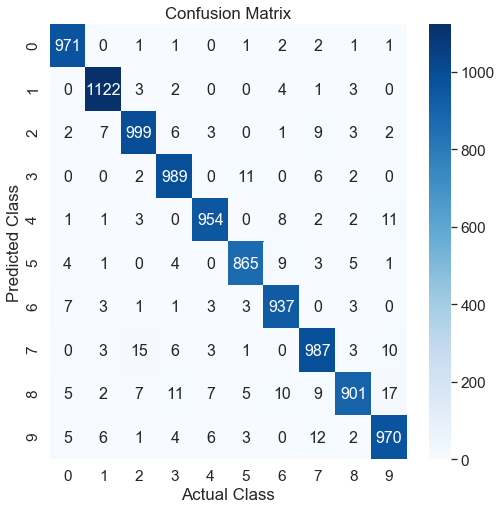

In [137]:
pred = CNN.predict_classes(pre_test_images)
cm = confusion_matrix(test_labels, pred)

columns = np.unique(test_labels)
df_cm = DataFrame(cm, index=columns, columns=columns)

plt.figure(figsize=(8,8))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, fmt='g',cmap='Blues',annot_kws={"size": 16}) # font size
ax.set(xlabel='Actual Class', ylabel='Predicted Class')
ax.set_title('Confusion Matrix')

# 4. Visualization of Prediction

Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [142]:
predictions = CNN.predict(pre_test_images)

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(columns[predicted_label],
                                100*np.max(predictions_array),
                                columns[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

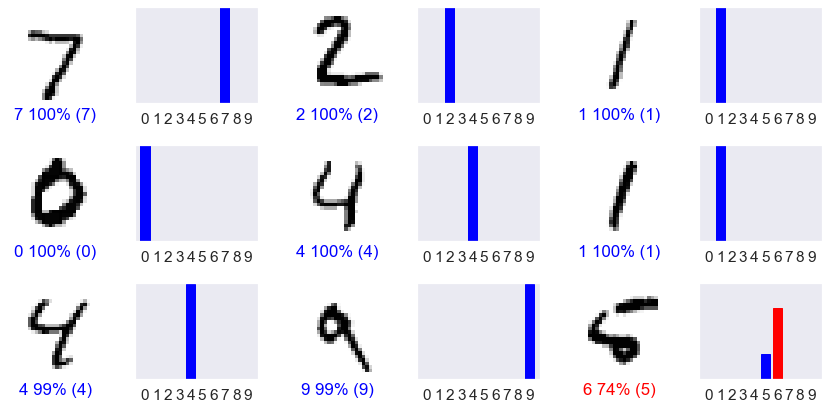

In [145]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()